## Problem Statement

Credit Card Lead Prediction

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.


The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 


In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.


Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

    Customer details (gender, age, region etc.)
    Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)


## Deciding Models

In [56]:
from pyspark.sql import SparkSession
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

In [57]:
# Load Train dataset
train_sdf = pd.read_csv('train_s3TEQDk.csv')

In [58]:
train_sdf.head(3)

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0

In [59]:
# This method gives us very nice descriptive statistics. We don't need this for now, but will later on!
train_sdf.describe()

Age        Vintage  Avg_Account_Balance        Is_Lead
count  245725.000000  245725.000000         2.457250e+05  245725.000000
mean       43.856307      46.959141         1.128403e+06       0.237208
std        14.828672      32.353136         8.529364e+05       0.425372
min        23.000000       7.000000         2.079000e+04       0.000000
25%        30.000000      20.000000         6.043100e+05       0.000000
50%        43.000000      32.000000         8.946010e+05       0.000000
75%        54.000000      73.000000         1.366666e+06       0.000000
max        85.000000     135.000000         1.035201e+07       1.000000

In [60]:
# Load Test Dataset
test_sdf = pd.read_csv('test_mSzZ8RL.csv')

In [61]:
test_sdf.head(3)

ID Gender  Age Region_Code Occupation Channel_Code  Vintage  \
0  VBENBARO   Male   29       RG254      Other           X1       25   
1  CCMEWNKY   Male   43       RG268      Other           X2       49   
2  VK3KGA9M   Male   31       RG270   Salaried           X1       14   

  Credit_Product  Avg_Account_Balance Is_Active  
0            Yes               742366        No  
1            NaN               925537        No  
2             No               215949        No

### Cleaning Data Set

In [62]:
train_sdf.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [63]:
test_sdf.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

### Clean missing data - Impute missing data from frequently used values

In [64]:
# Iterate over each column of train_sdf
for col in train_sdf.columns:
    # Check if the column is of object type
    if train_sdf[col].dtypes == 'object':
        # Impute with the most frequent value
        train_sdf = train_sdf.fillna(train_sdf[col].value_counts().index[0])

# Count the number of NaNs in the dataset and print the counts to verify
train_sdf.isnull().values.sum()

0

In [65]:
# Iterate over each column of test_sdf
for col in test_sdf.columns:
    # Check if the column is of object type
    if test_sdf[col].dtypes == 'object':
        # Impute with the most frequent value
        test_sdf = test_sdf.fillna(test_sdf[col].value_counts().index[0])

# Count the number of NaNs in the dataset and print the counts to verify
test_sdf.isnull().values.sum()

0

In [66]:
# #Imputing with Mode
# train_sdf['Credit_Product']= train_sdf['Credit_Product'].fillna(train_sdf['Credit_Product'].mode()[0])
# test_sdf['Credit_Product']= test_sdf['Credit_Product'].fillna(test_sdf['Credit_Product'].mode()[0])

In [67]:
train_sdf.head(3)

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0

In [68]:
predict_test = test_sdf['ID']

In [69]:
predict_test.head(3)

0    VBENBARO
1    CCMEWNKY
2    VK3KGA9M
Name: ID, dtype: object

### Exploratory Data Analysis

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Credit_Product', ylabel='count'>

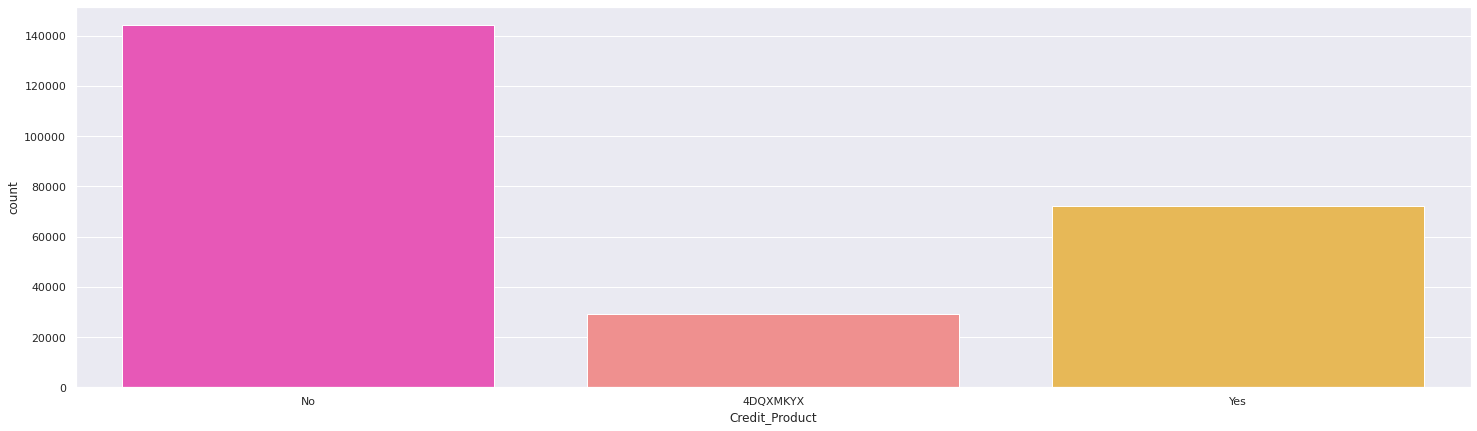

In [70]:
plt.figure(figsize=(25,7))
sns.countplot('Credit_Product',data=train_sdf,palette='spring')

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Vintage', ylabel='count'>

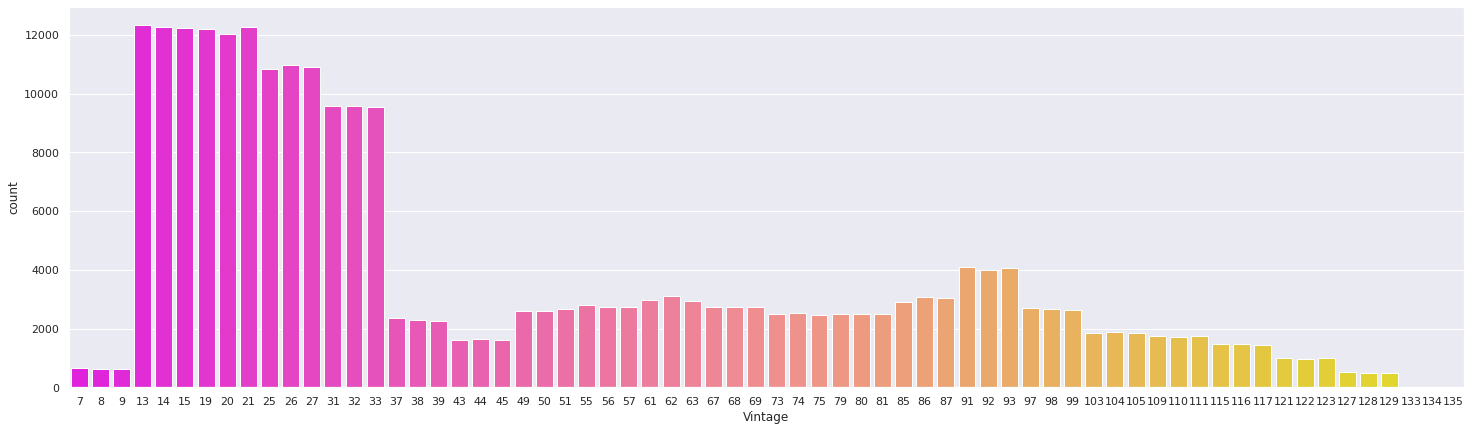

In [71]:
plt.figure(figsize=(25,7))
sns.countplot('Vintage',data=train_sdf,palette='spring')

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Region_Code', ylabel='count'>

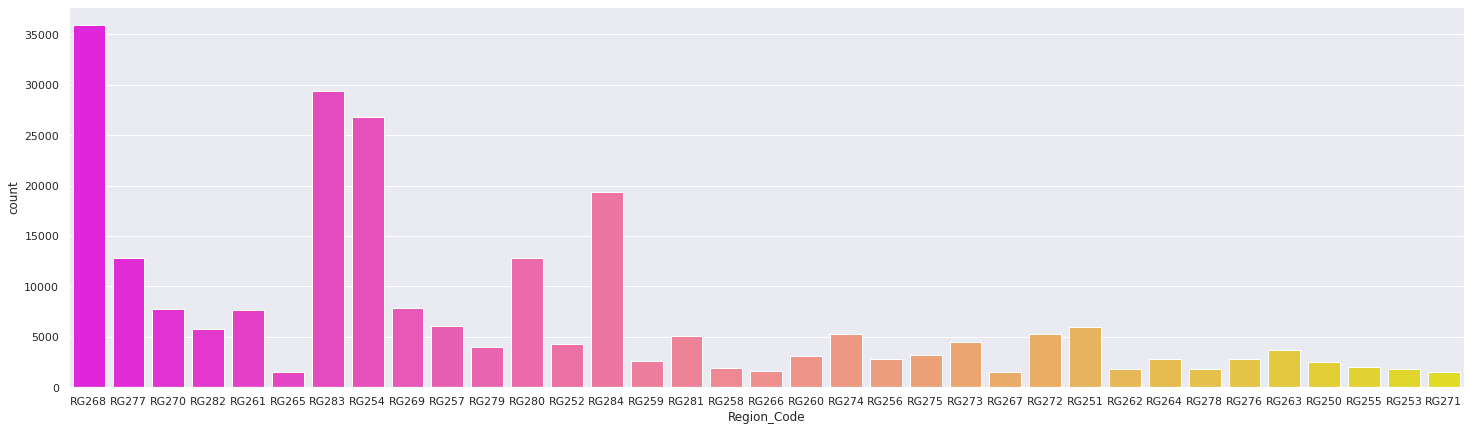

In [72]:
plt.figure(figsize=(25,7))
sns.countplot('Region_Code',data=train_sdf,palette='spring')

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Channel_Code', ylabel='count'>

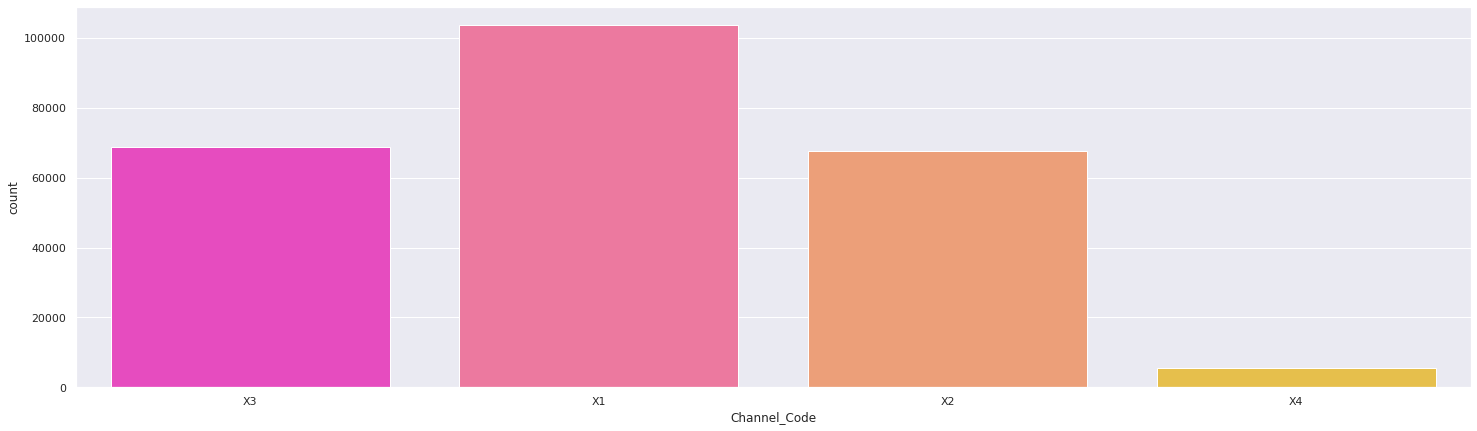

In [73]:
plt.figure(figsize=(25,7))
sns.countplot('Channel_Code',data=train_sdf,palette='spring')

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age', ylabel='count'>

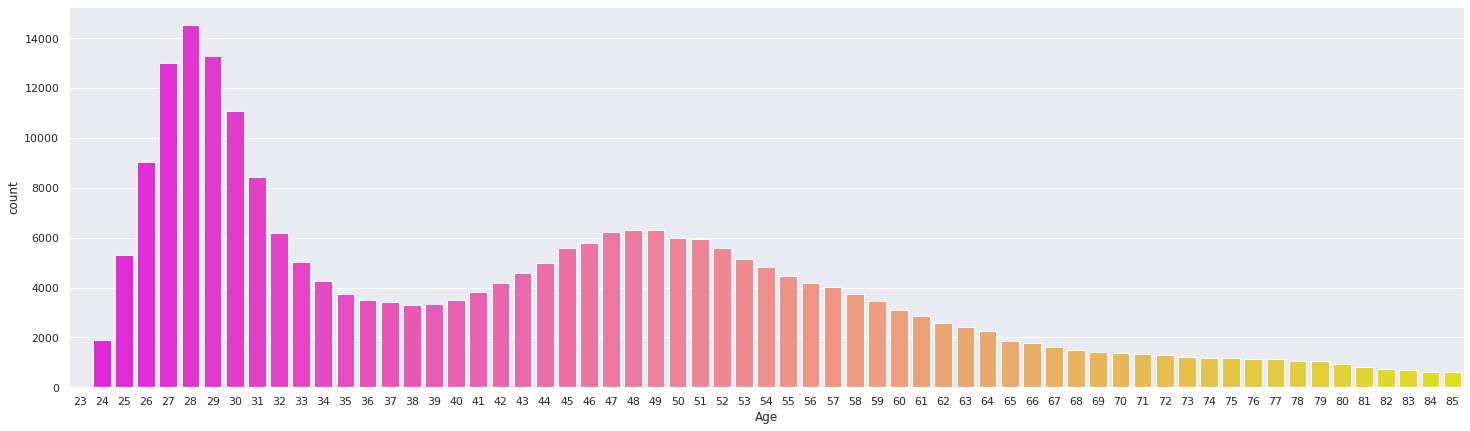

In [74]:
plt.figure(figsize=(25,7))
sns.countplot('Age',data=train_sdf,palette='spring')

## Relationship between the features and label

/usr/local/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


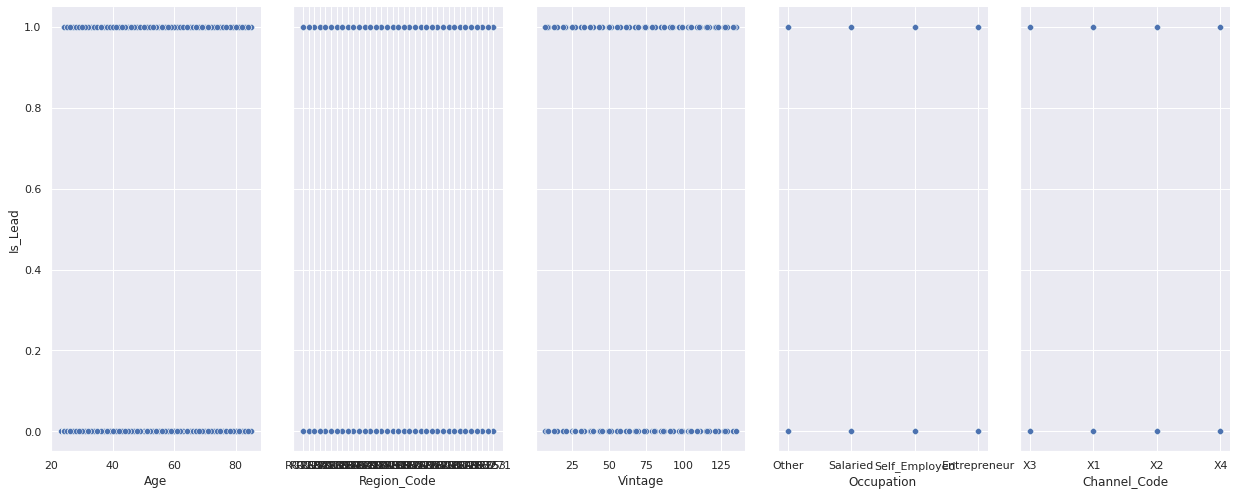

In [75]:
sns.pairplot(train_sdf, x_vars=['Age', 'Region_Code', 'Vintage', 'Occupation', 'Channel_Code']
                 , y_vars='Is_Lead', size=7, aspect=0.5)

### Convert Categorial Value to Integer

In [76]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
le = LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in train_sdf.columns:
    # Compare if the dtype is object
    if train_sdf[col].dtype=='object':
    # Use LabelEncoder to do the numeric transformation
        train_sdf[col]=le.fit_transform(train_sdf[col])

In [77]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
le = LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in test_sdf.columns:
    # Compare if the dtype is object
    if test_sdf[col].dtype=='object':
    # Use LabelEncoder to do the numeric transformation
        test_sdf[col]=le.fit_transform(test_sdf[col])

In [78]:
train_sdf.head(3)

ID  Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0  179194       0   73           18           1             2       43   
1  131013       0   30           27           2             0       32   
2  121520       0   56           18           3             2       26   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  
0               1              1045696          0        0  
1               1               581988          0        0  
2               1              1484315          1        0

In [79]:
test_sdf.head(3)

ID  Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0  94233       1   29            4           1             0       25   
1  28747       1   43           18           1             1       49   
2  94883       1   31           20           2             0       14   

   Credit_Product  Avg_Account_Balance  Is_Active  
0               2               742366          0  
1               0               925537          0  
2               1               215949          0

<AxesSubplot:>

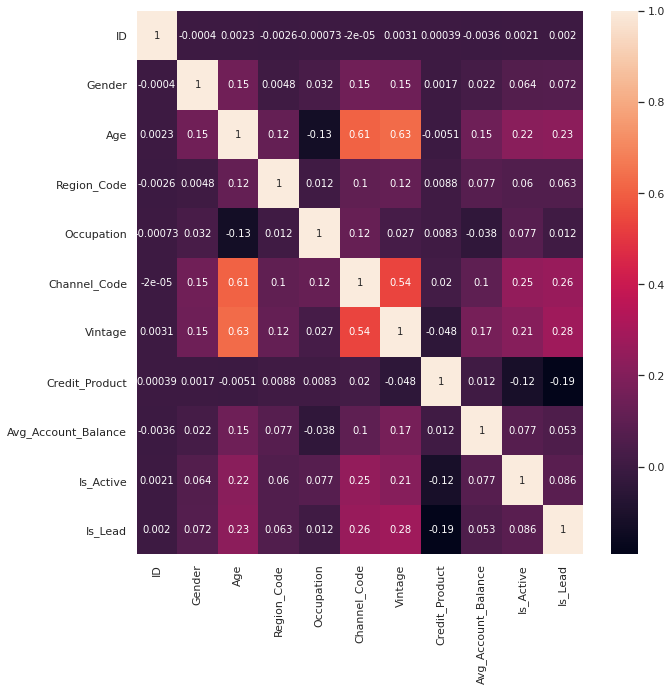

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig= plt.figure(figsize=(10,10))
corr = train_sdf.corr()
sns.heatmap(corr, annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Select Features

In [81]:
xs =train_sdf.drop(['Is_Lead', 'ID', 'Avg_Account_Balance'], axis=1)
ys =train_sdf['Is_Lead']

In [82]:
xs_train,xs_test,ys_train,ys_test=train_test_split(xs, ys,test_size=0.2)
xs_train.head(2)

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
104237       0   29            7           2             0       26   
193294       1   63           18           1             0       97   

        Credit_Product  Is_Active  
104237               1          0  
193294               1          1

In [83]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as pyplot

fs = SelectKBest(score_func=chi2, k='all')
fs.fit(xs_train, ys_train)
xs_train_fs = fs.transform(xs_train)
xs_test_fs = fs.transform(xs_test)

Feature 0: 431.591689
Feature 1: 52208.591664
Feature 2: 4758.748174
Feature 3: 13.322696
Feature 4: 11664.391304
Feature 5: 343304.978325
Feature 6: 2445.741413
Feature 7: 883.957091


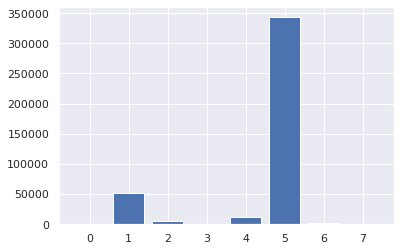

In [84]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

## TRAIN AND TEST

In [30]:
x =train_sdf[['Vintage', 'Age', 'Channel_Code', 'Region_Code', 'Occupation', 'Credit_Product']]
y =train_sdf['Is_Lead']

In [31]:
x_train,x_test,y_train,y_test=train_test_split(x, y,test_size=0.2)
x_train.head(2)

Vintage  Age  Channel_Code  Region_Code  Occupation  Credit_Product
219841       45   49             1            7           1               2
16560        31   28             0            4           1               1

### Decision Tree Classifier

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 

 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1,stratify=y)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape) 

clf_tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=100)
clf_tree_gini.fit(X_train, y_train)

y_pred=clf_tree_gini.predict(X_test)


print ("Accuracy : ", 
accuracy_score(y_test,y_pred)*100) 

Accuracy :  84.97507376131854


In [33]:
pickling_on = open("decisiontree_model_gini.pickle","wb")
pickle.dump(clf_tree_gini, pickling_on)
pickling_on.close()

In [34]:
# pickle_off = open("decisiontree_model_gini.pickle", 'rb')
# load_model = pickle.load(pickle_off)
# load_model.predict(X_test)

## Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
clf_LogisticRegression = LogisticRegression()

clf_LogisticRegression.fit(X_train,y_train)

pred_train = clf_LogisticRegression.predict(X_train)
pred_test = clf_LogisticRegression.predict(X_test)

y_pred=clf_LogisticRegression.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,y_train)
accuracy_test = accuracy_score(y_pred,y_test)

print(accuracy_test)

0.7838437277444298


In [36]:
pickling_on = open("logistic_regression.pickle","wb")
pickle.dump(clf_LogisticRegression, pickling_on)
pickling_on.close()

In [ ]:
# pickle_off = open("logistic_regression.pickle", 'rb')
# load_model = pickle.load(pickle_off)
# load_model.predict(X_test)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_random_forest = RandomForestClassifier()

clf_random_forest.fit(X_train,y_train)

pred_train = clf_random_forest.predict(X_train)
pred_test = clf_random_forest.predict(X_test)

accuracy_train = accuracy_score(pred_train,y_train)
accuracy_test = accuracy_score(pred_test,y_test)

from sklearn import metrics


print(accuracy_train,accuracy_test)

In [ ]:
pickling_on = open("random_forest.pickle","wb")
pickle.dump(clf_random_forest, pickling_on)
pickling_on.close()

In [ ]:
prediction_test_ds = test_sdf[['Vintage', 'Age', 'Channel_Code', 'Region_Code', 'Occupation', 'Credit_Product']]

In [ ]:
prediction_test_ds.head(3)

In [ ]:
pickle_off = open("random_forest.pickle", 'rb')
load_model = pickle.load(pickle_off)
final_predictions = load_model.predict(prediction_test_ds)

In [ ]:
test_sdf['Is_Lead'] = final_predictions

In [ ]:
test_sdf.head(3)

In [ ]:
rf_submission_df = pd.merge(test_sdf, predict_test, left_index=True, right_index=True)

In [ ]:
rf_submission = rf_submission_df[['ID_y', 'Is_Lead']]

In [ ]:
rf_submission.columns = ['ID', 'Is_Lead']

In [ ]:
rf_submission.to_csv('random_forest_final_submission.csv', sep = ',', index=False)

In [ ]:
rf_submission.describe()

##### Features and Labels

In [37]:
features_train = X_train
label_train = y_train
features_test =X_test
label_test = y_test

## Gaussian Model

In [38]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import accuracy_score
clf_gauss = GaussianNB()

clf_gauss.fit(features_train,label_train)

pred_train = clf_gauss.predict(features_train)
pred_test = clf_gauss.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)



print(accuracy_train,accuracy_test)

0.7873639230847492 0.786326177637603


In [39]:
pickling_on = open("gaussian.pickle","wb")
pickle.dump(clf_gauss, pickling_on)
pickling_on.close()

In [ ]:
# pickle_off = open("random_forest.pickle", 'rb')
# load_model = pickle.load(pickle_off)
# load_model.predict(X_test)

## Linear Regression

In [ ]:
# Labelencoding

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
le = LabelEncoder()
var_mod = train_sdf.select_dtypes(include='object').columns
for i in var_mod:
    train[i] = le.fit_transform(train_sdf[i])
    
for i in var_mod:
    test_sdf[i] = le.fit_transform(test_sdf[i])

In [ ]:
# Seperate Features and Target
X= train_sdf[['Vintage', 'Age', 'Channel_Code', 'Region_Code', 'Occupation', 'Credit_Product']]
y= train_sdf['Is_Lead']

In [ ]:
# 20% data as validation set
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=22)

In [ ]:
# Model Building
features= X.columns
LR = LinearRegression(normalize=True)
LR.fit(X_train,y_train)
y_pred = LR.predict(X_valid)
coef = pd.Series(LR.coef_,features).sort_values()


In [ ]:
# Barplot for coefficients
plt.figure(figsize=(8,5))
sns.barplot(LR.coef_,features)

#### RMSE

In [ ]:
MSE= metrics.mean_squared_error(y_valid,y_pred)
from math import sqrt
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

In [ ]:
test = test_sdf[['Vintage', 'Age', 'Channel_Code', 'Region_Code', 'Occupation', 'Credit_Product']]

In [ ]:
final_predictions = LR.predict(test)

In [ ]:
test_sdf['Is_Lead'] = final_predictions

In [ ]:
lr_submission_df = pd.merge(test_sdf, predict_test, left_index=True, right_index=True)

In [ ]:
lr_submission = lr_submission_df[['ID_y', 'Is_Lead']]

In [ ]:
lr_submission.columns = ['ID', 'Is_Lead']

In [ ]:
lr_submission.to_csv('linear_regression_final_submission.csv', sep = ',', index=False)

In [ ]:
lr_submission.describe()

In [ ]:
lr_submission.isnull().sum()

## Gradient Boosting Classifier

In [40]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

clf_gradient = GradientBoostingClassifier()

clf_gradient.fit(features_train,label_train)

pred_train = clf_gradient.predict(features_train)
pred_test = clf_gradient.predict(features_test)


accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

print(accuracy_train,accuracy_test)
print(pred_test)

0.8589022281005189 0.8592532302370536
[0 1 0 ... 1 1 0]


In [41]:
pickling_on = open("GBClassifier.pickle","wb")
pickle.dump(clf_gradient, pickling_on)
pickling_on.close()

In [42]:
prediction_test_ds = test_sdf[['Vintage', 'Age', 'Channel_Code', 'Region_Code', 'Occupation', 'Credit_Product']]

In [43]:
prediction_test_ds.head(3)

Vintage  Age  Channel_Code  Region_Code  Occupation  Credit_Product
0       25   29             0            4           1               2
1       49   43             1           18           1               0
2       14   31             0           20           2               1

In [44]:
pickle_off = open("GBClassifier.pickle", 'rb')
load_model = pickle.load(pickle_off)
final_predictions = load_model.predict(prediction_test_ds)

In [45]:
print(final_predictions)

[0 1 0 ... 0 0 0]


In [46]:
test_sdf['Is_Lead'] = final_predictions

In [47]:
test_sdf.head(3)

ID  Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0  94233       1   29            4           1             0       25   
1  28747       1   43           18           1             1       49   
2  94883       1   31           20           2             0       14   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  
0               2               742366          0        0  
1               0               925537          0        1  
2               1               215949          0        0

In [48]:
gb_submission_df = pd.merge(test_sdf, predict_test, left_index=True, right_index=True)

In [49]:
gb_submission_df.head(3)

ID_x  Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0  94233       1   29            4           1             0       25   
1  28747       1   43           18           1             1       49   
2  94883       1   31           20           2             0       14   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead      ID_y  
0               2               742366          0        0  VBENBARO  
1               0               925537          0        1  CCMEWNKY  
2               1               215949          0        0  VK3KGA9M

In [50]:
gb_submission = gb_submission_df[['ID_y', 'Is_Lead']]

In [51]:
gb_submission.head(3)

ID_y  Is_Lead
0  VBENBARO        0
1  CCMEWNKY        1
2  VK3KGA9M        0

In [52]:
gb_submission.columns = ['ID', 'Is_Lead']

In [53]:
gb_submission.to_csv('gradient_boosting_final_submission.csv', sep = ',', index=False)

In [54]:
gb_submission.describe()

Is_Lead
count  105312.000000
mean        0.153183
std         0.360165
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

In [55]:
gb_submission.isnull().sum()

ID         0
Is_Lead    0
dtype: int64

## For this data set, let's go with Gradient Boosting Classifier applied to get final submission